In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
from scipy import stats

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# Functions

In [2]:
#convert numpy datasets to pandas dataframe
def dataset_to_dataframe(dataset):
    data = np.c_[dataset.data, dataset.target]
    columns = np.append(dataset.feature_names, ["target"])
    return pd.DataFrame(data, columns=columns)

In [3]:
#convert the data in each feature column to be [0, 1]
def normalize_data(data, classes_in, drop_time=True):
    #normalized_data = (data - data.min()) / (data.max() - data.min())
    
    normalized_data = data.copy()
    for col in data.columns:
        min = data[col].min()
        max = data[col].max()
        if (min == max):
            normalized_data.drop(col, axis=1, inplace=True)
        else:
            normalized_data[col] = (data[col] - min) / (max - min)
        
        if (not drop_time and col == "timestamps"):
            normalized_data[col] *= (max - min)
    
    #don't normalize last label indicating classes
    if (classes_in == True):
        normalized_data[normalized_data.columns[-1]] = data[data.columns[-1]]
        
    return normalized_data

In [4]:
def remove_outliers(data):
    #removes all outliers from data to get more normally distributed data
    data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]
    return data

In [5]:
#preprocess the data (collected data) by:
# - removing timestamp column
# - replacing nan values in each column with the column's mean
# - normalizing each column to be between [0, 1]
def preprocess_data(data, classes_in, drop_time=True):
    if drop_time:
        data.drop("timestamps", axis=1, inplace=True)
    
    data = data.dropna(axis='columns')
    data = remove_outliers(data)
    data = normalize_data(data, classes_in, drop_time)
    return data

In [6]:
#preprocess the data (online data) by:
# - removing time column
# - removing columns with nan values (common in online data)
# - normalizing each column to be between [0, 1]
def preprocess_online(data, classes_in):
    data.drop("time",axis=1,inplace=True)
    data = data.dropna(axis='columns')
    #data = data.drop("FT8",axis=1)
    #data = data.drop("C3",axis=1)
    #data = data.drop("T5",axis=1)
    data = remove_outliers(data)
    data = normalize_data(data, classes_in)
    return data

In [7]:
def print_accuracy(y_true, y_pred):
    print(confusion_matrix(y_true, y_pred))
    print(f1_score(y_true, y_pred, average=None))
    print("Total accuracy: ", f1_score(y_true, y_pred, average='weighted'))

In [8]:
def new_prediction_output(model, new_data, drowsy):    
    #preprocess the new data (no class labels)
    new_data = preprocess_data(new_data, False, False)
    
    #grab timestamps values for plot
    timestamps = new_data["timestamps"].values
    new_data.drop("timestamps", axis=1, inplace=True)
    
    #create array representing true labels
    label_array = np.empty(new_data.shape[0])
    if drowsy:
        label_array.fill(1)
    else:
        label_array.fill(0)
    y_true = pd.Series(label_array)
    
    #use model to predict new data and time it
    pred_time = time.time()
    predictions = model.predict(new_data)
    pred_time = time.time() - pred_time
    
    print("Time to predict: ", pred_time)
    print_accuracy(y_true, predictions)

    #plot the predicted labels
    plt.figure(figsize=(8, 3), dpi=80)
    plt.scatter(timestamps, predictions, marker=11)

# Collected Data

In [9]:
#data = pd.read_csv("ddds_data/Coady_tab_ratios_Ca1-4_Cd1-4.csv")
data = pd.read_csv("../MuseData/collected/Combined_tab_ratios_C1-4_A1-4.csv")
#data = pd.read_csv("../MuseData/collected/Ali_tab_ratios_all.csv")
data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta,drowsy
0,0.000000,1.393897,19.657931,14.102854,0.698588,3.226497,4.618594,0.471769,2.441642,5.175499,0.592905,9.731784,16.413729,0
1,0.390625,1.345214,14.201284,10.556894,0.802288,2.836738,3.535808,0.497057,2.348465,4.724736,0.419712,6.807784,16.220122,0
2,0.781250,1.376599,17.476509,12.695423,0.720597,2.800141,3.885862,0.484561,2.459058,5.074813,0.398788,4.230435,10.608228,0
3,1.171875,0.926220,19.627759,21.191257,0.721316,3.310595,4.589660,0.549909,2.645507,4.810810,0.207802,5.036814,24.238506,0
4,1.562500,0.829537,18.081652,21.797281,0.596472,3.643569,6.108532,0.297639,2.179708,7.323331,0.236304,5.018854,21.239004,0
5,1.953125,0.877075,17.931958,20.445175,0.712352,4.252872,5.970182,0.290570,1.820448,6.265085,0.266463,5.009631,18.800462,0
6,2.343750,0.936006,17.254009,18.433653,0.717602,4.535007,6.319665,0.275977,1.702108,6.167575,0.320963,5.597954,17.441094,0
7,2.734375,1.173901,18.563157,15.813226,0.435956,3.820578,8.763687,0.173772,1.904830,10.961683,0.403068,6.872372,17.050138,0
8,3.125000,0.997297,18.450409,18.500407,0.442068,3.947797,8.930301,0.173126,1.727258,9.976912,0.358538,7.238494,20.188911,0
9,3.515625,1.120943,20.382879,18.183693,0.343398,4.001565,11.652843,0.224801,2.442777,10.866415,0.403209,7.578854,18.796346,0


<AxesSubplot:xlabel='AF7_alpha_to_theta', ylabel='Count'>

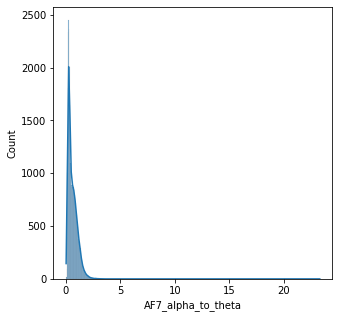

In [19]:
# check normal distributions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data, x=data.columns[4], kde=True)

<AxesSubplot:xlabel='AF7_alpha_to_theta', ylabel='Count'>

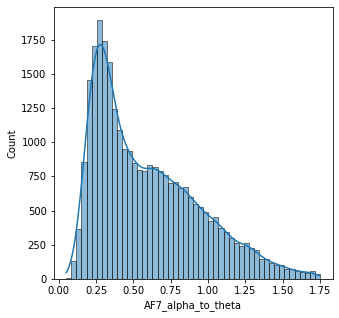

In [21]:
#removing outliers
data = remove_outliers(data)
# check normal distributions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data, x=data.columns[4], kde=True)

<AxesSubplot:xlabel='AF7_alpha_to_theta', ylabel='Count'>

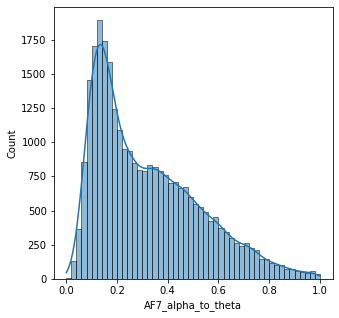

In [22]:
#normalizing data
data = normalize_data(data, True)
# check normal distributions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))
sns.histplot(data, x=data.columns[4], kde=True)

In [24]:
data = preprocess_data(data, True)
data.head(10)

,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta,drowsy
0,0.355217,0.559632,0.057137,0.280718,0.284850,0.112117,0.330988,0.225007,0.103135,0.211271,0.433017,0.070370,0
1,0.342625,0.402872,0.041895,0.325616,0.246994,0.083935,0.350794,0.214292,0.092737,0.147349,0.299341,0.069483,0
2,0.350743,0.496963,0.051087,0.290247,0.243440,0.093046,0.341007,0.227009,0.100812,0.139627,0.181514,0.043782,0
3,0.234249,0.558765,0.087605,0.290558,0.293019,0.111364,0.392186,0.248450,0.094723,0.069137,0.218379,0.106206,0
4,0.209241,0.514348,0.090210,0.236506,0.325360,0.150895,0.194612,0.194886,0.152675,0.079657,0.217558,0.092469,0
5,0.221537,0.510047,0.084398,0.286677,0.384540,0.147295,0.189076,0.153574,0.128266,0.090788,0.217136,0.081301,0
6,0.236780,0.490571,0.075752,0.288950,0.411943,0.156391,0.177647,0.139965,0.126017,0.110903,0.244032,0.075075,0
7,0.298313,0.528181,0.064488,0.167009,0.342552,0.220001,0.097602,0.163277,0.236596,0.141206,0.302294,0.073285,0
8,0.252634,0.524942,0.076039,0.169655,0.354909,0.224337,0.097096,0.142857,0.213881,0.124771,0.319032,0.087659,0
9,0.284615,0.580458,0.074678,0.126935,0.360131,0.295197,0.137567,0.225137,0.234398,0.141258,0.334592,0.081282,0


<AxesSubplot:>

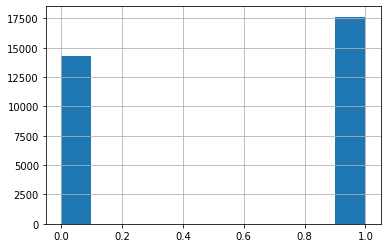

In [25]:
#check how many positives and negatives there are in the dataset
data[data.columns[-1]].hist()

In [26]:
n_classes = len(np.unique(data[data.columns[-1]]))
n_features = len(data.columns) - 1
print("Number of classes: ", n_classes)
print("Number of features: ", n_features)

Number of classes:  2
Number of features:  12


In [27]:
#split up data into training and testing
train, test = train_test_split(data, test_size=0.2, random_state=17)
x_train = train.iloc[:,:-1] # all rows, columns up until last(target)
y_train = train.iloc[:, -1] # all rows, only target column
x_test = test.iloc[:, :-1]
y_test = test.iloc[:, -1]

In [28]:
#K-FOLD CROSS VALIDATION
# prepare the cross-validation procedure
cv = KFold(n_splits=10, random_state=1, shuffle=True)
data_x = data.iloc[:,:-1]
data_y = data.iloc[:, -1]
# evaluate model
model = svm.SVC(kernel = 'rbf', random_state = 0)
scores = cross_val_score(model, data_x, data_y, scoring='accuracy', cv=cv, n_jobs=-1)

In [29]:
print(scores)
print("Accuracy:\n mean - %.3f\nstdev - %.3f" % (np.mean(scores), np.std(scores)))

[0.85231539 0.8600939  0.85007825 0.86040689 0.86510172 0.85696401
 0.85758998 0.84694836 0.86259781 0.85226917]
Accuracy:
 mean - 0.856
stdev - 0.006


In [32]:
#TRAINING
model = svm.SVC(kernel = 'rbf', random_state = 1)
model.fit(x_train, y_train)

SVC(random_state=1)

In [33]:
#TESTING
prediction_time = time.time()
y_pred = model.predict(x_test)
prediction_time = time.time() - prediction_time
print("Time to predict: ", prediction_time)

print_accuracy(y_test, y_pred)

Time to predict:  4.266014814376831
[[2245  618]
 [ 333 3195]]
[0.82521595 0.87045362]
Total accuracy:  0.8501883324862117


# Testing on new data

In [355]:
#TESTING (FULL AWAKE) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_full_awake_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_full_awake_2min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.165053,18.482805,111.981340,0.159045,9.017529,56.698002,0.136359,7.972278,58.465240,0.162784,19.140866,117.584712
1,0.390625,0.161829,18.730496,115.742452,0.154892,8.579934,55.392833,0.133546,7.244259,54.245392,0.157764,18.258537,115.733521
2,0.781250,0.118177,15.909688,134.625463,0.139887,8.731147,62.415551,0.145116,7.521488,51.830688,0.131099,16.172888,123.363939
3,1.171875,0.121036,24.961822,206.234427,0.152572,9.303534,60.977939,0.145062,7.303669,50.348754,0.131490,24.803012,188.630317
4,1.562500,0.122525,26.798663,218.719976,0.154341,8.202602,53.146111,0.154366,7.184240,46.540235,0.136364,29.149050,213.758928
5,1.953125,0.122364,26.323663,215.125650,0.152572,8.348317,54.717321,0.151184,7.309948,48.351345,0.135802,30.406455,223.902198
6,2.343750,0.117946,29.776455,252.459056,0.160719,9.747485,60.649270,0.146919,7.344021,49.986942,0.126815,28.826352,227.309739
7,2.734375,0.379276,27.356292,72.127619,0.190330,10.557464,55.469246,0.220485,8.484031,38.478940,0.398659,24.882732,62.416138
8,3.125000,0.151253,28.178765,186.302768,0.200817,10.309662,51.338615,0.181339,6.546266,36.099585,0.142974,24.672829,172.568591
9,3.515625,0.152488,23.720243,155.554349,0.233594,5.868330,25.121920,0.263484,5.407634,20.523561,0.144154,26.767651,185.688462


In [356]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

29


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
29,11.328125,0.145413,15.608455,107.339124,0.281785,5.319587,18.878172,0.322113,7.470146,23.191037,0.146585,12.720874,86.781520
30,11.718750,0.148568,15.179822,102.174049,0.320937,5.902516,18.391513,0.317718,7.665864,24.127861,0.143871,13.585858,94.431013
31,12.109375,0.142916,11.786786,82.473623,0.361956,5.379233,14.861552,0.336519,7.224074,21.467034,0.135047,11.701799,86.650100
32,12.500000,0.221286,13.519118,61.093519,0.411065,4.603006,11.197747,0.372971,6.367450,17.072249,0.221577,13.456861,60.732341
33,12.890625,0.181352,13.339806,73.557675,0.372931,5.445379,14.601574,0.325742,6.543482,20.087936,0.180161,13.748961,76.314675
34,13.281250,0.183807,15.654371,85.167367,0.360129,5.296663,14.707687,0.313021,6.052415,19.335505,0.180164,14.433280,80.111961
35,13.671875,0.219941,16.299244,74.107251,0.352945,5.221374,14.793715,0.356771,6.499507,18.217601,0.221855,18.287830,82.431464
36,14.062500,0.108613,10.940058,100.725377,0.331042,4.394037,13.273334,0.380367,6.664823,17.522104,0.128809,11.594558,90.013873
37,14.453125,0.097825,7.994843,81.725906,0.337274,4.477491,13.275533,0.348157,5.160608,14.822666,0.110530,8.292593,75.025986
38,14.843750,0.138583,8.622094,62.215995,0.286341,4.092673,14.292998,0.397827,5.986324,15.047544,0.149983,8.233779,54.898005


Time to predict:  0.055742502212524414
[[53 21]
 [ 0  0]]
[0.83464567 0.        ]
Total accuracy:  0.8346456692913385


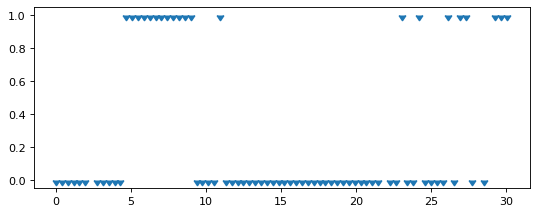

In [357]:
new_prediction_output(model, new_data, False)

In [358]:
#TESTING (LESS AWAKE) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_less_awake_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_less_awake_5min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.158626,12.585895,79.343023,0.123252,3.319840,26.935431,0.223840,6.658052,29.744707,0.147982,11.474701,77.541158
1,0.390625,0.218613,11.884330,54.362409,0.187807,4.576153,24.366284,0.262949,6.933687,26.368939,0.181642,10.175502,56.019618
2,0.781250,0.174894,8.059944,46.084717,0.274345,3.294939,12.010198,0.299016,5.818263,19.458041,0.144724,9.123429,63.040009
3,1.171875,0.109801,13.874092,126.356163,0.199500,4.480347,22.457903,0.293866,5.904517,20.092529,0.088190,13.332681,151.180650
4,1.562500,0.128448,12.018419,93.566288,0.199443,4.036385,20.238268,0.316678,5.585753,17.638601,0.096867,11.092748,114.515817
5,1.953125,0.134597,11.195285,83.176644,0.195400,3.862577,19.767534,0.254852,5.086919,19.960278,0.105260,10.827169,102.861523
6,2.343750,0.137955,10.862834,78.741820,0.198169,3.873109,19.544489,0.271314,4.441700,16.371095,0.118463,10.450719,88.219596
7,2.734375,0.120119,7.910059,65.851972,0.246919,4.337111,17.564944,0.324153,4.361370,13.454656,0.102133,7.536561,73.791841
8,3.125000,0.137808,9.644634,69.986009,0.243378,4.733413,19.448828,0.349577,4.742047,13.565105,0.122675,9.683093,78.932946
9,3.515625,0.127470,8.710929,68.336927,0.254704,4.901908,19.245539,0.304806,4.762338,15.624164,0.119668,9.483225,79.245813


In [359]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

48


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
48,18.750000,0.097271,12.294683,126.395716,0.168826,5.660792,33.530390,0.204934,6.868062,33.513580,0.097486,8.751172,89.768391
49,19.140625,0.185346,22.568209,121.762323,0.179060,5.395357,30.131601,0.381665,10.810572,28.324800,0.226222,22.843942,100.980338
50,19.531250,0.112211,18.368750,163.697808,0.165078,5.652505,34.241467,0.204401,6.692821,32.743597,0.125889,15.164271,120.457804
51,19.921875,0.114102,17.191165,150.665395,0.156049,5.427101,34.778178,0.194671,6.136414,31.521921,0.131097,14.607250,111.423496
52,20.312500,0.117530,19.646159,167.159328,0.154455,5.750303,37.229660,0.159605,5.800921,36.345403,0.131746,15.151672,115.006415
53,20.703125,0.119089,24.510225,205.815158,0.133444,7.228100,54.165914,0.120618,5.455202,45.227241,0.128485,17.790075,138.460191
54,21.093750,0.123870,22.736778,183.554076,0.133200,7.140413,53.606810,0.121549,5.470630,45.007437,0.138419,15.523168,112.146214
55,21.484375,0.122062,23.820252,195.149308,0.115959,6.799966,58.641178,0.118410,5.123797,43.271744,0.138570,16.516059,119.188972
56,21.875000,0.146398,30.439152,207.921052,0.130420,7.798026,59.791513,0.097439,5.345856,54.863811,0.149350,20.915919,140.046168
57,22.265625,0.123708,30.534911,246.831450,0.120669,7.038332,58.327769,0.084381,4.656625,55.185440,0.130161,21.238312,163.169267


Time to predict:  0.05254983901977539
[[63 12]
 [ 0  0]]
[0.91304348 0.        ]
Total accuracy:  0.9130434782608696


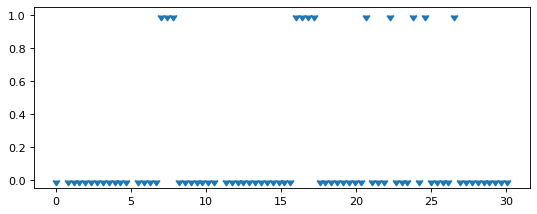

In [360]:
new_prediction_output(model, new_data, False)

In [361]:
#TESTING (DROWSY) VALUES
#new_data = pd.read_csv("../MuseData/collected/testing/Ali_drowsy_30s_mid_tab_ratios.csv")
new_data = pd.read_csv("../MuseData/Ali_drowsy_5min_power_3ratios.csv")
new_data.head(10)

,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
0,0.000000,0.086606,8.505008,98.203156,0.187474,1.456433,7.768725,0.138756,1.959830,14.124246,0.078155,7.595378,97.182998
1,0.390625,0.085640,7.965850,93.015088,0.220069,1.535399,6.976911,0.197540,2.456021,12.433011,0.079002,7.134720,90.310573
2,0.781250,0.123306,7.106320,57.631612,0.461755,2.000413,4.332196,0.158782,2.067823,13.023032,0.112051,7.707600,68.786381
3,1.171875,0.093424,7.747101,82.923764,0.370776,2.004240,5.405522,0.182728,2.099344,11.488888,0.083391,7.812531,93.685335
4,1.562500,0.093498,7.714956,82.514323,0.447336,2.239269,5.005787,0.234527,2.796302,11.923174,0.086841,8.410625,96.851038
5,1.953125,0.074497,6.147838,82.524816,0.377218,2.087970,5.535180,0.219743,2.329554,10.601245,0.062834,6.058051,96.413399
6,2.343750,0.087896,6.268845,71.321265,0.411308,2.175303,5.288746,0.246074,2.500478,10.161505,0.082574,6.206028,75.157458
7,2.734375,0.073030,7.151763,97.928478,0.397423,2.201344,5.539042,0.198225,2.185789,11.026788,0.061565,6.411448,104.140641
8,3.125000,0.077253,6.524558,84.457514,0.370445,1.962266,5.297053,0.199082,2.039129,10.242664,0.060282,5.246767,87.036739
9,3.515625,0.097847,6.022920,61.554451,0.300051,1.824309,6.079993,0.168996,2.030589,12.015591,0.076235,4.362584,57.225343


In [362]:
rand_start = random.randint(0, new_data.shape[0] - 78 - 1)
print(rand_start)
new_data = new_data.iloc[rand_start:rand_start + 78, :]
new_data.head(10)

307


,timestamps,TP9_alpha_to_theta,TP9_alpha_to_beta,TP9_theta_to_beta,AF7_alpha_to_theta,AF7_alpha_to_beta,AF7_theta_to_beta,AF8_alpha_to_theta,AF8_alpha_to_beta,AF8_theta_to_beta,TP10_alpha_to_theta,TP10_alpha_to_beta,TP10_theta_to_beta
307,119.921875,0.082891,3.629549,43.787028,0.266783,0.739704,2.772679,0.395970,1.584298,4.001058,0.079382,2.984264,37.593870
308,120.312500,0.070862,4.246974,59.932683,0.258471,0.857314,3.316869,0.328186,1.746204,5.320775,0.066255,3.785408,57.133732
309,120.703125,0.131693,3.761158,28.559982,0.299997,0.936147,3.120523,0.418052,1.743702,4.171023,0.139931,3.914740,27.976220
310,121.093750,0.125279,3.200755,25.548916,0.306148,0.953449,3.114340,0.483706,2.016225,4.168282,0.143628,3.284391,22.867321
311,121.484375,0.116588,3.031302,26.000078,0.377786,1.136818,3.009160,0.405176,1.820226,4.492433,0.140504,3.393515,24.152412
312,121.875000,0.142543,2.898529,20.334445,0.377873,1.154233,3.054553,0.414688,1.630877,3.932781,0.181453,3.379543,18.624934
313,122.265625,0.179804,3.186039,17.719472,0.360514,2.209052,6.127513,0.277510,2.115580,7.623433,0.190808,3.179478,16.663234
314,122.656250,0.186048,2.970885,15.968385,0.371279,2.223056,5.987556,0.236501,1.767034,7.471583,0.167547,2.690449,16.057848
315,123.046875,0.164463,3.676643,22.355486,0.467469,2.346462,5.019498,0.242756,2.351282,9.685767,0.217337,4.344674,19.990495
316,123.437500,0.235276,4.405065,18.722971,0.439668,2.378277,5.409250,0.256126,2.429398,9.485181,0.269232,4.513132,16.762961


Time to predict:  0.0534210205078125
[[ 0  0]
 [42 32]]
[0.         0.60377358]
Total accuracy:  0.6037735849056604


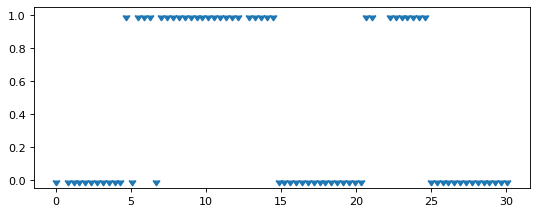

In [363]:
new_prediction_output(model, new_data, True)

# Online Data

In [327]:
on_data = pd.read_csv("ddds_data/online/Online_power_f1-7_m1-7.csv")
on_data.head(10)

,time,HEOL,HEOR,FP1,FP2,VEOU,VEOL,F7,F3,FZ,...,T6,A2,O1,OZ,O2,FT9,FT10,PO1,PO2,drowsy
0,0,2.057207,0.270608,5.564671,NaN,5.397345,6.279081,8.347633,6.260097,6.946177,...,6.113396,3.427360,NaN,6.516418,6.260097,10.792013,0.63596,14.332133,6.260097,0
1,4,1.069318,1.000000,1.995987,NaN,2.005905,6.279081,1.954402,6.260097,2.067475,...,6.113396,1.045627,NaN,2.588555,6.260097,0.415328,0.63596,2.944453,6.260097,0
2,8,0.781610,1.057375,2.230398,0.671261,2.538961,6.279081,3.582768,6.260097,1.490852,...,6.113396,0.883249,0.844458,3.678384,6.260097,1.600655,0.63596,4.486340,6.260097,0
3,12,1.029504,1.167187,1.592974,1.014722,2.385655,6.279081,2.937494,6.260097,2.240476,...,6.113396,1.007121,1.009158,2.970995,6.260097,0.913129,0.63596,3.377619,6.260097,0
4,16,0.806222,2.680043,3.968202,6.260097,2.525516,6.279081,3.250421,6.260097,1.779741,...,6.113396,2.411728,2.235222,3.962315,6.260097,2.511730,0.63596,5.534334,6.260097,0
5,20,1.101267,0.923014,2.503400,6.260097,1.592368,6.279081,1.096549,6.260097,1.394355,...,6.113396,2.066296,1.793097,1.906889,6.260097,1.677505,0.63596,2.462544,6.260097,0
6,24,1.324937,1.028199,1.675918,6.260097,2.010825,6.279081,3.565451,6.260097,2.056296,...,6.113396,1.914223,3.088796,2.487217,6.260097,2.279378,0.63596,2.459002,6.260097,0
7,28,0.909504,0.893794,1.176636,6.260097,1.212359,6.279081,3.198073,6.260097,1.301796,...,6.113396,0.958917,3.642419,1.342567,6.260097,1.307847,0.63596,1.772131,6.260097,0
8,32,1.400576,0.276718,1.048151,6.260097,1.235531,6.279081,1.642246,6.260097,1.036500,...,6.113396,0.763651,6.260097,1.959409,6.260097,1.638884,0.63596,1.880299,6.260097,0
9,36,0.704878,0.276718,1.401058,6.260097,1.812097,6.279081,2.131769,6.260097,1.524662,...,6.113396,1.033130,6.260097,2.443189,6.260097,2.694694,0.63596,2.554038,6.260097,0


In [328]:
on_data = preprocess_online(on_data, True)
on_data.head(10)

,HEOL,FP1,VEOU,F7,FZ,F8,FC3,FC4,FT8,T3,...,CP4,A1,T5,P3,P4,A2,OZ,FT9,PO1,drowsy
1,0.238617,0.597942,0.449865,0.420614,0.445550,0.180138,0.342765,0.258790,0.999662,0.470165,...,0.533549,0.501360,0.792766,0.384707,0.243605,0.305867,0.555423,0.084087,0.583243,0
2,0.173692,0.668800,0.571836,0.776258,0.320572,0.108799,0.318072,0.165071,0.999662,0.638516,...,0.788809,0.683182,0.792766,0.444828,0.261660,0.257770,0.790433,0.335219,0.890896,0
3,0.229632,0.476119,0.536758,0.635326,0.483046,0.210886,0.342346,0.213278,0.999662,0.504189,...,0.714525,0.516529,0.792766,0.320132,0.240494,0.294461,0.637892,0.189555,0.669673,0
5,0.245827,0.751324,0.355242,0.233254,0.299657,0.154909,0.356636,0.137085,0.999662,0.250949,...,0.385808,0.248111,0.792766,0.150440,0.161727,0.608194,0.408429,0.351501,0.487088,0
6,0.296301,0.501192,0.450991,0.772475,0.443127,0.242971,0.328875,0.284316,0.999662,0.493377,...,0.576580,0.506050,0.792766,0.457618,0.354771,0.563149,0.533570,0.479018,0.486381,0
7,0.202553,0.350268,0.268290,0.692238,0.279596,0.158117,0.184319,0.116045,0.999662,0.249360,...,0.237385,0.243866,0.792766,0.178724,0.138256,0.280183,0.286739,0.273182,0.349329,0
8,0.313370,0.311430,0.273592,0.352437,0.222096,0.124387,0.435552,0.164926,0.999662,0.266267,...,0.428539,0.242513,0.792766,0.149503,0.146426,0.222344,0.419754,0.343318,0.370912,0
9,0.156376,0.418106,0.405519,0.459352,0.327900,0.139825,0.396554,0.158265,0.999662,0.476108,...,0.466804,0.386853,0.792766,0.233560,0.162439,0.302165,0.524076,0.567010,0.505344,0
10,0.169741,0.420697,0.299709,0.202762,0.215066,0.098915,0.372582,0.139323,0.999662,0.323651,...,0.417388,0.264887,0.792766,0.229126,0.164017,0.291133,0.411153,0.353662,0.463589,0
11,0.074865,0.379467,0.191608,0.169056,0.177432,0.088488,0.135057,0.101492,0.999662,0.195637,...,0.176043,0.208706,0.792766,0.139890,0.130580,0.257807,0.337984,0.218816,0.390421,0


<AxesSubplot:>

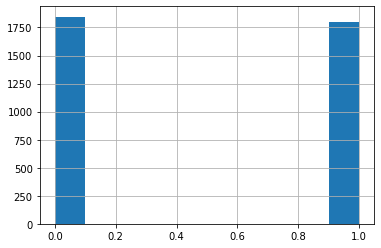

In [329]:
#check how many positives and negatives there are in the dataset
on_data[on_data.columns[-1]].hist()

In [330]:
on_n_classes = len(np.unique(on_data[on_data.columns[-1]]))
on_n_features = len(on_data.columns) - 1
print("Number of classes: ", on_n_classes)
print("Number of features: ", on_n_features)

Number of classes:  2
Number of features:  23


array([[<AxesSubplot:title={'center':'HEOL'}>,
        <AxesSubplot:title={'center':'FP1'}>,
        <AxesSubplot:title={'center':'VEOU'}>,
        <AxesSubplot:title={'center':'F7'}>,
        <AxesSubplot:title={'center':'FZ'}>],
       [<AxesSubplot:title={'center':'F8'}>,
        <AxesSubplot:title={'center':'FC3'}>,
        <AxesSubplot:title={'center':'FC4'}>,
        <AxesSubplot:title={'center':'FT8'}>,
        <AxesSubplot:title={'center':'T3'}>],
       [<AxesSubplot:title={'center':'C3'}>,
        <AxesSubplot:title={'center':'CZ'}>,
        <AxesSubplot:title={'center':'T4'}>,
        <AxesSubplot:title={'center':'CP3'}>,
        <AxesSubplot:title={'center':'CP4'}>],
       [<AxesSubplot:title={'center':'A1'}>,
        <AxesSubplot:title={'center':'T5'}>,
        <AxesSubplot:title={'center':'P3'}>,
        <AxesSubplot:title={'center':'P4'}>,
        <AxesSubplot:title={'center':'A2'}>],
       [<AxesSubplot:title={'center':'OZ'}>,
        <AxesSubplot:title={'center':'FT9

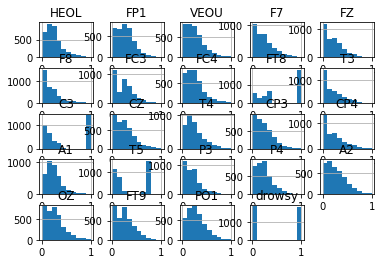

In [331]:
on_data.hist()

In [332]:
#TRAIN/TEST SPLIT
from sklearn.model_selection import train_test_split

#split up data into training and testing
on_train, on_test = train_test_split(on_data, test_size=0.2, random_state=27)
on_x_train = on_train.iloc[:,:-1] # all rows, columns up until last(target)
on_y_train = on_train.iloc[:, -1] # all rows, only target column
on_x_test = on_test.iloc[:, :-1]
on_y_test = on_test.iloc[:, -1]

In [333]:
#K-FOLD CROSS VALIDATION
# prepare the cross-validation procedure
on_cv = KFold(n_splits=10, random_state=1, shuffle=True)
on_data_x = on_data.iloc[:,:-1]
on_data_y = on_data.iloc[:, -1]
# evaluate model
model2 = svm.SVC(kernel = 'rbf', random_state = 0)
on_scores = cross_val_score(model2, on_data_x, on_data_y, scoring='accuracy', cv=on_cv, n_jobs=-1)

In [334]:
print(on_scores)
print("Accuracy:\n mean - %.3f\nstdev - %.3f" % (np.mean(scores), np.std(scores)))

[0.97260274 0.9890411  0.97260274 0.99178082 0.99178082 0.97260274
 0.97534247 0.98082192 0.98082192 0.96978022]
Accuracy:
 mean - 0.980
stdev - 0.008


In [335]:
#TRAINING
model2 = svm.SVC(kernel = 'rbf')
model2.fit(on_x_train, on_y_train)

SVC()

In [365]:
#TESTING
on_y_pred = model2.predict(on_x_test)
print_accuracy(on_y_test, on_y_pred)

[[349  15]
 [  5 361]]
[0.97214485 0.97304582]
Total accuracy:  0.9725965686622893
